In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import re
import numpy as np
import pandas as pd
from datetime import date, datetime

In [2]:
# check steam dataset
pd.read_csv('steam_cleaned.csv').head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [3]:
# define function to remove all non-english games
def remove_non_english(df):
    # keep only rows marked as supporting english
    df = df[df['english'] == 1].copy()
    
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    # remove english column, now redundant
    df = df.drop('english', axis=1)
    
    return df

In [4]:
# define function for rating score based on SteamDB method
def calc_rating(row):
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

In [5]:
# define function to process categories & genres
def process_cat_gen_tag(df):
    # only going to use these categories
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (only keeping 'main' genres similar to steam store)
    gen_cols = [
        'Action',
        'Adventure',
        'Casual',
        'Indie',
        'Massively Multiplayer',
        'RPG',
        'Racing',
        'Simulation',
        'Sports',
        'Strategy'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # remove "non-games" based on genre
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()

    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags', 'genres'], axis=1)
    
    return df

In [6]:
# define function to preprocess steam dataset for model
def pre_process():
    df = pd.read_csv('steam_cleaned.csv')
    
    # keep english only
    df = remove_non_english(df)
    
    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()
    
    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    
    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    df['release_month'] = df['release_date'].apply(lambda x: x.month)
    
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process()

print('Verify no missing values:')
print(data.isnull().sum().value_counts())
data.head()

Verify no missing values:
0    30
dtype: int64


,appid,name,release_date,developer,publisher,required_age,achievements,positive_ratings,negative_ratings,average_playtime,...,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,0,124534,3339,17612,...,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,0,3318,633,277,...,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,0,3416,398,187,...,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,0,1273,267,258,...,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,0,5250,288,624,...,1,0,0,0,0,0,0,0,0,0


In [7]:
# pick top 10 developers
dev_cols = [
    'Valve',
    'id Software',
    'Ubisoft Montreal',
    'Bethesda Game Studios',
    'Daedalic Entertainment',
    'CAPCOM Co., Ltd.',
    'Klei Entertainment',
    'Square Enix',
    'CD PROJEKT RED',
    'The Behemoth'
]

# transform developer column
data.loc[~data["developer"].isin(dev_cols), "developer"] = "Other"

In [8]:
from sklearn.preprocessing import OneHotEncoder

# creating another instance of one-hot-encoder
oe_style = OneHotEncoder()

# pass publisher column
encoded_dev_df = pd.DataFrame(oe_style.fit_transform(data[["developer"]]).toarray(), columns=oe_style.categories_)

# add prefix to column names
encoded_dev_df = encoded_dev_df.add_prefix('developer_')

# check encoded publishers
encoded_dev_df.head()

,developer_Bethesda Game Studios,"developer_CAPCOM Co., Ltd.",developer_CD PROJEKT RED,developer_Daedalic Entertainment,developer_Klei Entertainment,developer_Other,developer_Square Enix,developer_The Behemoth,developer_Ubisoft Montreal,developer_Valve,developer_id Software
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# repeat for publishers
pub_cols = [
    'Ubisoft', 
    'Valve', 
    'Devolver Digital', 
    'Square Enix', 
    'SEGA',
    'Bethesda Softworks', 
    'THQ Nordic', 
    'Paradox Interactive',
    'Electronic Arts', 
    'Sekai Project'
]

# transform
data.loc[~data["publisher"].isin(pub_cols), "publisher"] = "Other"

In [10]:
# creating another instance of one-hot-encoder
oe_style = OneHotEncoder()

# pass publisher column
encoded_pub_df = pd.DataFrame(oe_style.fit_transform(data[["publisher"]]).toarray(), columns=oe_style.categories_)

# fix column names
encoded_pub_df = encoded_pub_df.add_prefix('publisher_')

# check encoded publishers
encoded_pub_df.head()

,publisher_Bethesda Softworks,publisher_Devolver Digital,publisher_Electronic Arts,publisher_Other,publisher_Paradox Interactive,publisher_SEGA,publisher_Sekai Project,publisher_Square Enix,publisher_THQ Nordic,publisher_Ubisoft,publisher_Valve
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
data.dtypes

appid                             int64
name                             object
release_date             datetime64[ns]
developer                        object
publisher                        object
required_age                      int64
achievements                      int64
positive_ratings                  int64
negative_ratings                  int64
average_playtime                  int64
median_playtime                   int64
owners                            int32
price                           float64
total_ratings                     int64
rating_ratio                    float64
rating                          float64
release_year                      int64
release_month                     int64
multi_player                      int64
single_player                     int64
action                            int64
adventure                         int64
casual                            int64
indie                             int64
massively_multiplayer             int64


In [12]:
# merge on key values
encoded_dev_pub_df = encoded_pub_df.join(encoded_dev_df)
encoded_dev_pub_df.head()

,publisher_Bethesda Softworks,publisher_Devolver Digital,publisher_Electronic Arts,publisher_Other,publisher_Paradox Interactive,publisher_SEGA,publisher_Sekai Project,publisher_Square Enix,publisher_THQ Nordic,publisher_Ubisoft,...,"developer_CAPCOM Co., Ltd.",developer_CD PROJEKT RED,developer_Daedalic Entertainment,developer_Klei Entertainment,developer_Other,developer_Square Enix,developer_The Behemoth,developer_Ubisoft Montreal,developer_Valve,developer_id Software
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# merge with main df
data = data.join(encoded_dev_pub_df)

# remove redundant columns
data = data[["release_date", "price", "average_playtime", "release_month", "release_year", "multi_player", "single_player", "sports", "total_ratings"]]

# check df
data.head()

,release_date,price,average_playtime,release_month,release_year,multi_player,single_player,sports,total_ratings
0,2000-11-01,7.19,17612,11,2000,1,0,0,127873
1,1999-04-01,3.99,277,4,1999,1,0,0,3951
2,2003-05-01,3.99,187,5,2003,1,0,0,3814
3,2001-06-01,3.99,258,6,2001,1,0,0,1540
4,1999-11-01,3.99,624,11,1999,1,1,0,5538


In [14]:
# ensure name is only object/categorical column remaining
data.dtypes

release_date        datetime64[ns]
price                      float64
average_playtime             int64
release_month                int64
release_year                 int64
multi_player                 int64
single_player                int64
sports                       int64
total_ratings                int64
dtype: object

In [15]:
# export
data.to_csv('steam_preproccessed.csv', index=False)

In [16]:
# Read game_data csv as a DF
games_df = pd.read_csv('steam_preproccessed.csv')
games_df

,release_date,price,average_playtime,release_month,release_year,multi_player,single_player,sports,total_ratings
0,2000-11-01,7.19,17612,11,2000,1,0,0,127873
1,1999-04-01,3.99,277,4,1999,1,0,0,3951
2,2003-05-01,3.99,187,5,2003,1,0,0,3814
3,2001-06-01,3.99,258,6,2001,1,0,0,1540
4,1999-11-01,3.99,624,11,1999,1,1,0,5538
...,...,...,...,...,...,...,...,...,...
25946,2019-04-24,2.09,0,4,2019,0,1,0,3
25947,2019-04-23,1.69,0,4,2019,0,1,0,9
25948,2019-04-24,3.99,0,4,2019,1,1,0,1
25949,2019-04-17,5.19,0,4,2019,0,1,0,2


In [17]:
# Calculate length_of_time by subracting todays date from the release date
# infer_datetime_format automatically parses date data as a datetime object
length_of_time = pd.to_datetime(games_df['release_date'], infer_datetime_format=True)
length_of_time

0       2000-11-01
1       1999-04-01
2       2003-05-01
3       2001-06-01
4       1999-11-01
           ...    
25946   2019-04-24
25947   2019-04-23
25948   2019-04-24
25949   2019-04-17
25950   2019-04-24
Name: release_date, Length: 25951, dtype: datetime64[ns]

In [18]:
# Displays today's date as a datetime object
today = datetime.now()

# Simple function that will be used to subtract today's date from the release_date
def days_between(d1, d2):
    return abs(d2 - d1)

length_of_time = days_between(length_of_time, today).dt.days

In [19]:
length_of_time

0        7872
1        8452
2        6961
3        7660
4        8238
         ... 
25946    1124
25947    1125
25948    1124
25949    1131
25950    1124
Name: release_date, Length: 25951, dtype: int64

In [20]:
# Add new calculation to the main dataframe
games_df["length_of_time"] = length_of_time
games_df

,release_date,price,average_playtime,release_month,release_year,multi_player,single_player,sports,total_ratings,length_of_time
0,2000-11-01,7.19,17612,11,2000,1,0,0,127873,7872
1,1999-04-01,3.99,277,4,1999,1,0,0,3951,8452
2,2003-05-01,3.99,187,5,2003,1,0,0,3814,6961
3,2001-06-01,3.99,258,6,2001,1,0,0,1540,7660
4,1999-11-01,3.99,624,11,1999,1,1,0,5538,8238
...,...,...,...,...,...,...,...,...,...,...
25946,2019-04-24,2.09,0,4,2019,0,1,0,3,1124
25947,2019-04-23,1.69,0,4,2019,0,1,0,9,1125
25948,2019-04-24,3.99,0,4,2019,1,1,0,1,1124
25949,2019-04-17,5.19,0,4,2019,0,1,0,2,1131


# Linear Regression

In [21]:
# Import Scikit-Learn library and intiate model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [35]:
# Assign variables
X = games_df.iloc[:, -1].values.reshape(-1, 1)
y = games_df.iloc[:, -2].values

In [36]:
# Split the dataset into four arrays and into two categories: train and test
# test_size set to .25
# random_state is a seed number that can be any integer
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [37]:
# Fit and train the model 
# Provide train and test scores
# The higher the score, the higher the accuracy of the model
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.003795277394392893
Testing Score: -0.013216409070881063


C:\Users\zobai\anaconda3\envs\mlenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

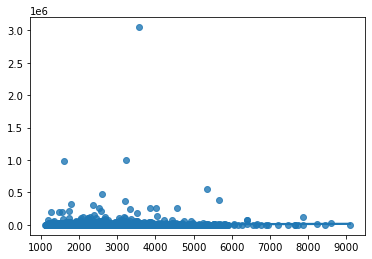

In [38]:
# seaborn automatically plots your variables with a best fit line
import seaborn as sns
sns.regplot(X_train, y_train)

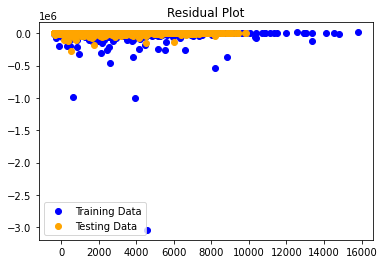

In [39]:
# Plot train and test data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.title("Residual Plot")
plt.show()

# RandomForestClassifier

In [56]:
# Assign variables
X = games_df.iloc[:, -1].values.reshape(-1, 1)
y = games_df.iloc[:, -2].values

In [57]:
# Split the dataset into four arrays and into two categories: train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.25, random_state=1)

In [58]:
# Import Scikit-Learn library and utilize RandomForestClassifier
# to make a classifier model
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(criterion='entropy')   
rf_clf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy')

In [59]:
# Test accuracy of the model
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
y_predict = rf_clf.predict(X_test)
accuracy_score(y_test,y_predict)

0.02250308261405672

In [ ]:
# Used the following documentation 
# https://machinelearningknowledge.ai/python-sklearn-random-forest-classifier-tutorial-with-example/
# https://pynative.com/python-difference-between-two-dates/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
# https://stackoverflow.com/questions/32490629/getting-todays-date-in-yyyy-mm-dd-in-python
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html#